In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import kaggle
import statsmodels.api as sm

plt.style.use('fivethirtyeight')

In [2]:
class CFG:
    img_dim1 = 20
    img_dim2 = 10



\begin{equation}
X_t = T_t + S_t + C_t + \epsilon_t
\end{equation}

Dedicated notebook: [https://www.kaggle.com/konradb/practical-time-series-pt-1-the-basics](https://www.kaggle.com/konradb/practical-time-series-pt-1-the-basics)

The first we can do to identify patterns in a time series is separate it into components with easily understandable characteristics:

\begin{equation}
X_t = T_t + S_t + C_t + I_t \quad
\end{equation}

where:
* $T_t$: the trend shows a general direction of the time series data over a long period of time. It represents a long-term progression of the series (secular variation)

* $S_t$: the seasonal component with fixed and known period. It is observed when there is a distinct repeated pattern observed between regular intervals due to seasonal factors: annual, monthly or weekly. Obvious examples include daily power consumption patterns or annual sales of seasonal goods.

* $C_t$: (optional) cyclical component is a repetitive pattern which does not occur at fixed intervals - usually observed in an economic context like business cycles.

* $I_t$: the irregular component (residuals ) consists of the fluctuations in the time series that are observed after removing trend and seasonal / cyclical variations.

In [3]:
os.getcwd()

'/home/noone/data-exercises/TimeSeries'

In [4]:
df = pd.read_csv("us_energy.csv")
df.head(3)

,date,value
0,1973-01-01,160.218
1,1973-01-31,143.539
2,1973-03-02,148.158


In [5]:
# Make sure we can represent it as a time series
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace = True)

<AxesSubplot:xlabel='date'>

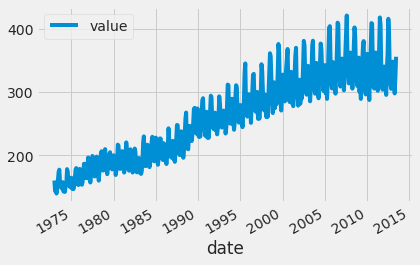

In [6]:
df.plot()

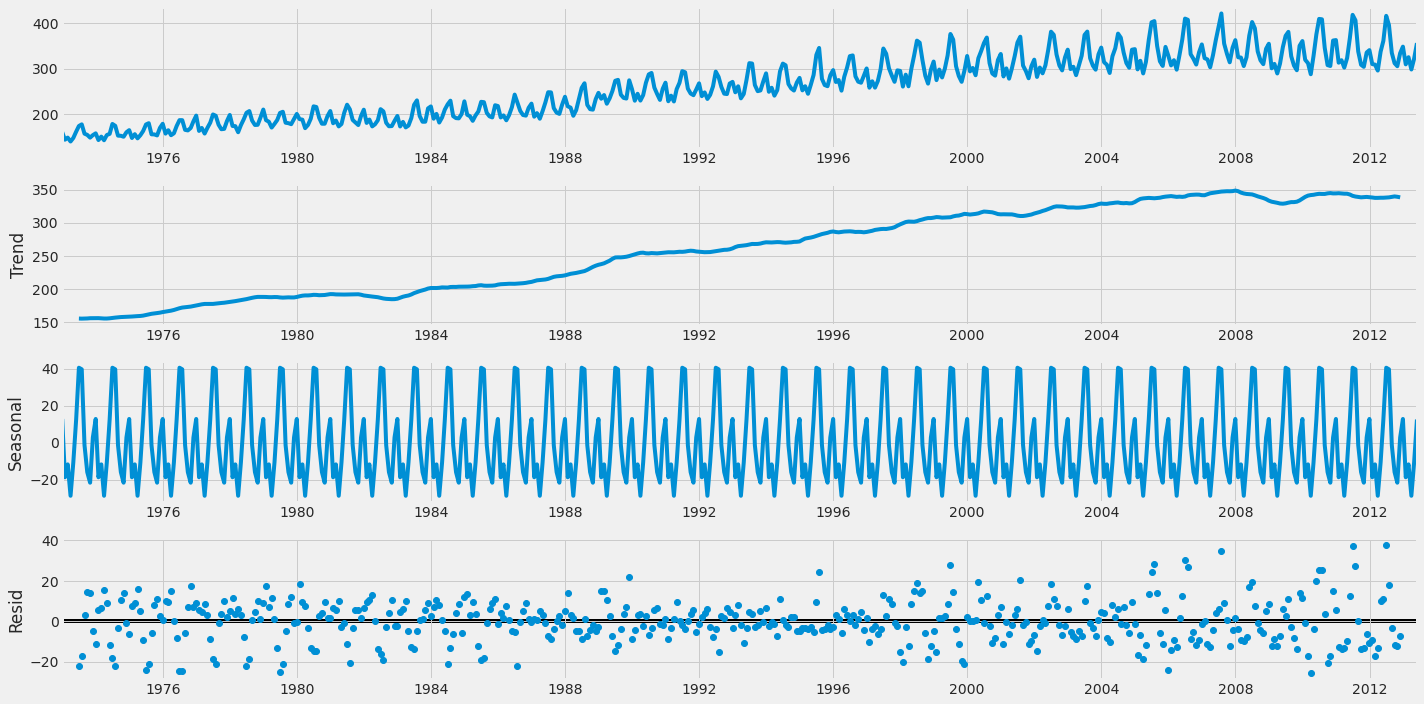

In [7]:
# Wrapper around the functionality in order to decompose trend and seasonal components
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams.update({'figure.figsize': (CFG.img_dim1, CFG.img_dim2)})

decomposition = seasonal_decompose(df, period = 12)
figure = decomposition.plot()
plt.show()

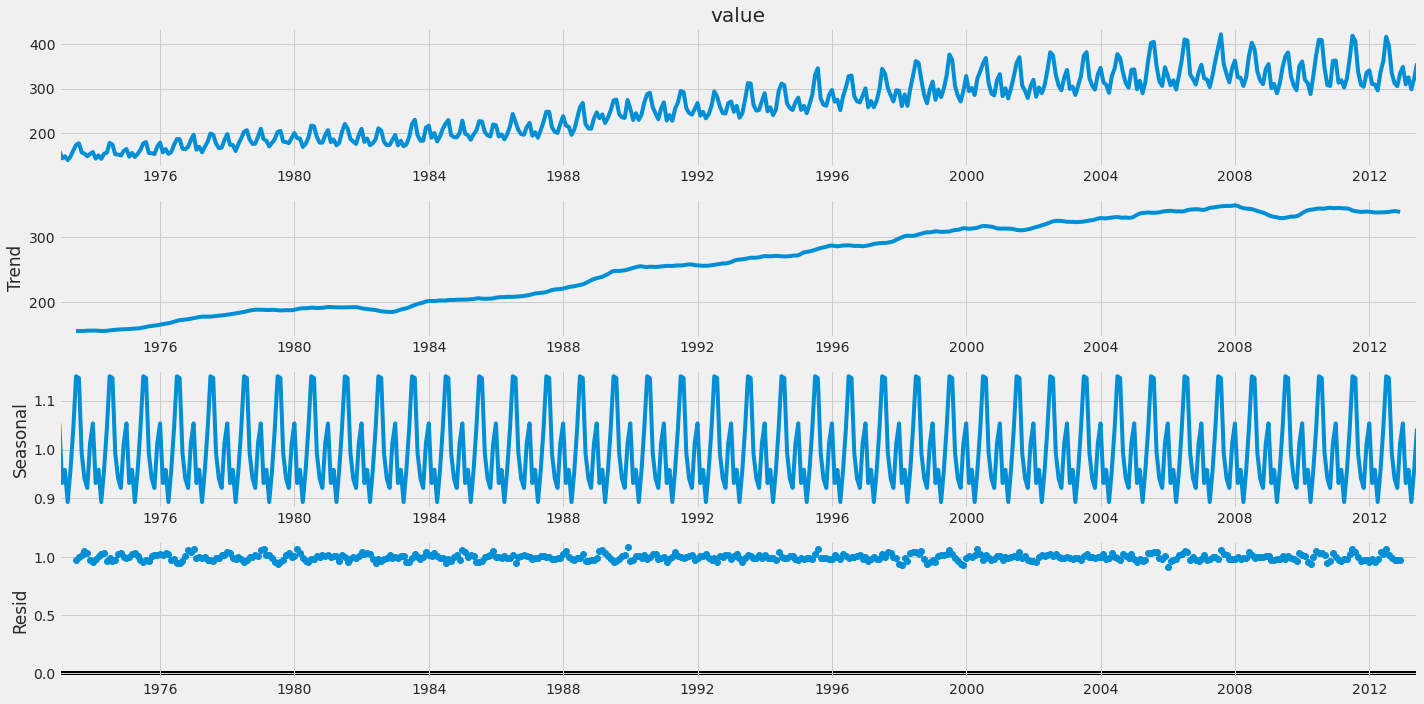

In [8]:
# Residual is the stuff the model can't figure out
# The residual gets higher spread as the series progresses, this can indicate that the model is not summative but multiplicative. Let's try it.
# If it's a warm day the sales of cold drinks increases x10000 (additive), if I expect to jump by x5 (multiplicative)
decomposition = seasonal_decompose(df['value'], period = 12, model = 'multiplicative')
figure = decomposition.plot()
plt.show()

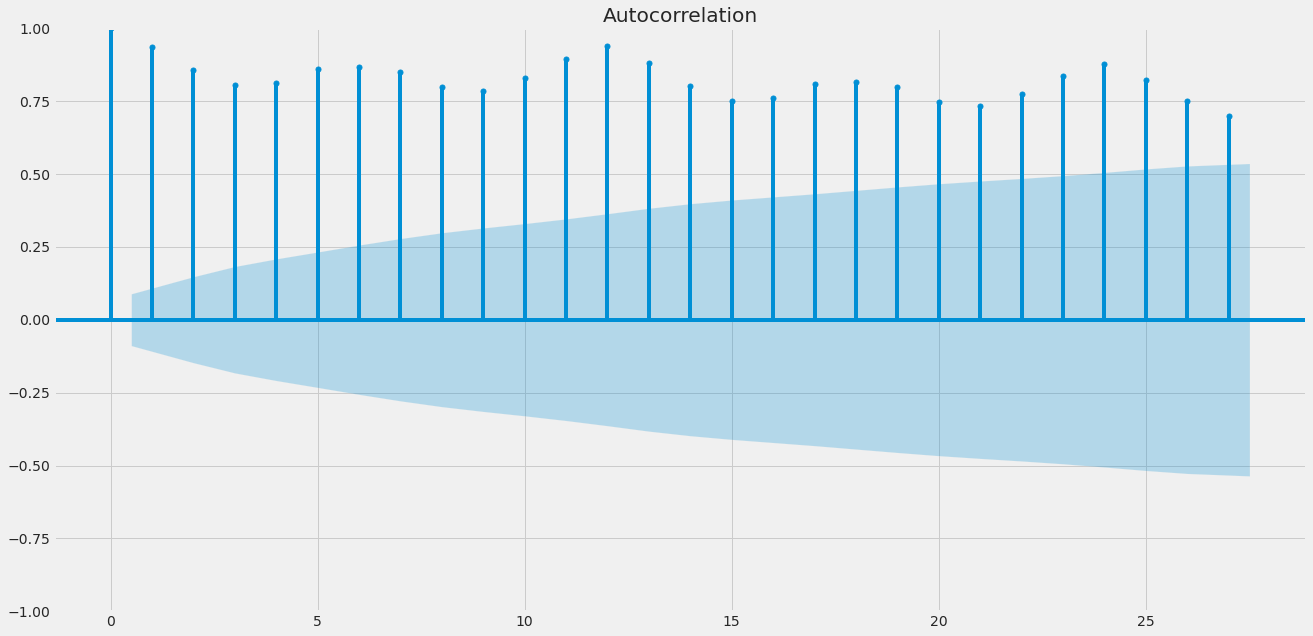

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF
plot_acf(df['value'])
print()

/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


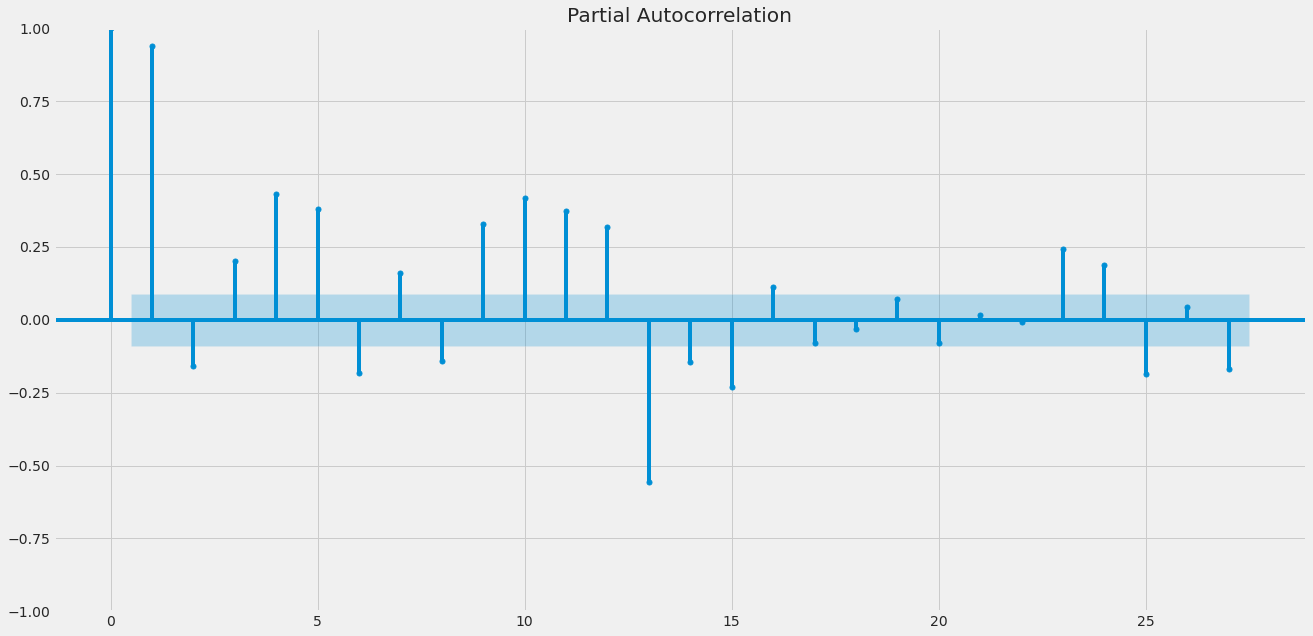

In [10]:
plot_pacf(df['value'])
print()

Dedicated notebook: [https://www.kaggle.com/konradb/practical-time-series-pt-2-smoothing-methods](https://www.kaggle.com/konradb/practical-time-series-pt-2-smoothing-methods)

In [11]:
# training / validation split
cutoff_date = '2005-12-31'
df['value'] /= 100
xtrain, xvalid = df.loc[df.index <= cutoff_date], df.loc[df.index > cutoff_date]
print(xtrain.shape, xvalid.shape)

(397, 1) (89, 1)


In [12]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

fit1 = ExponentialSmoothing(xtrain['value'].values, seasonal_periods= 12, trend= 'mul', seasonal= 'mul')

In [13]:
fit1 = fit1.fit()

/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [14]:
prediction = fit1.forecast(len(xvalid)).copy()

xresiduals = xvalid['value'] - prediction

In [15]:
fit1.params_formatted

,name,param,optimized
smoothing_level,alpha,2.817339e-01,True
smoothing_trend,beta,8.991375e-17,True
smoothing_seasonal,gamma,2.263639e-01,True
initial_level,l.0,1.516747e+00,True
initial_trend,b.0,1.001948e+00,True
initial_seasons.0,s.0,1.068678e+00,True
initial_seasons.1,s.1,9.413275e-01,True
initial_seasons.2,s.2,9.666158e-01,True
initial_seasons.3,s.3,8.982842e-01,True
initial_seasons.4,s.4,9.486115e-01,True


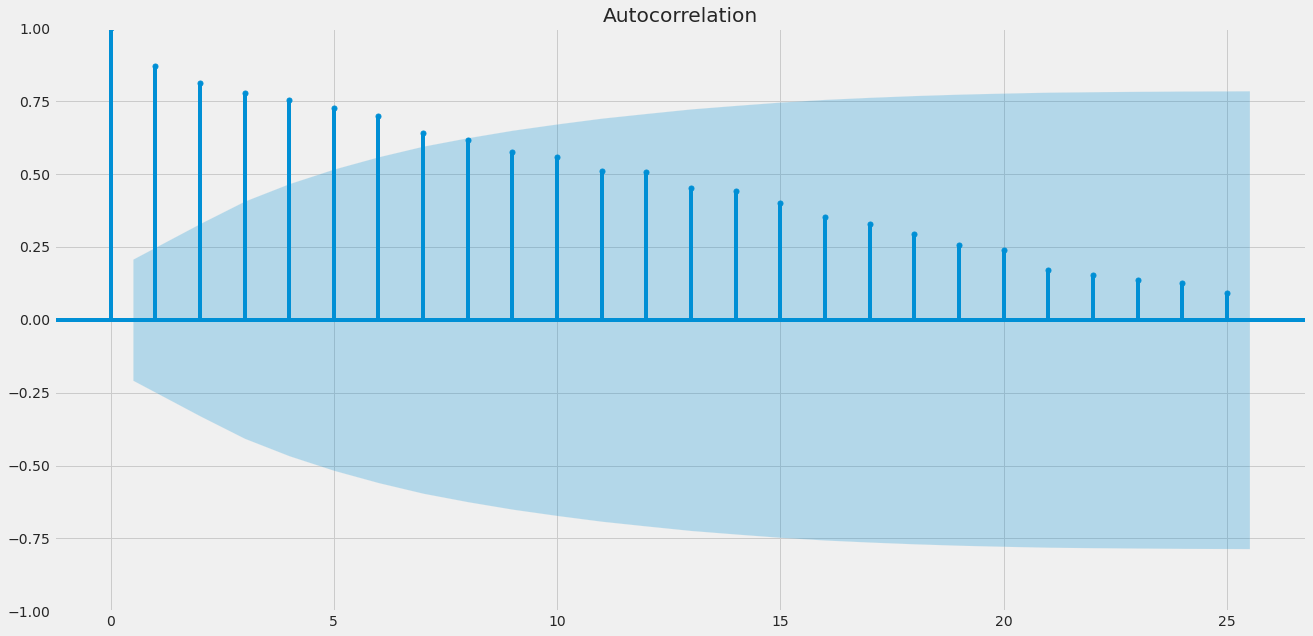

In [16]:
# alpha smoothing model
# beta smoothing trend
# gamma smoothing seasonality

plot_acf(xresiduals, lags = 25)
print()

/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


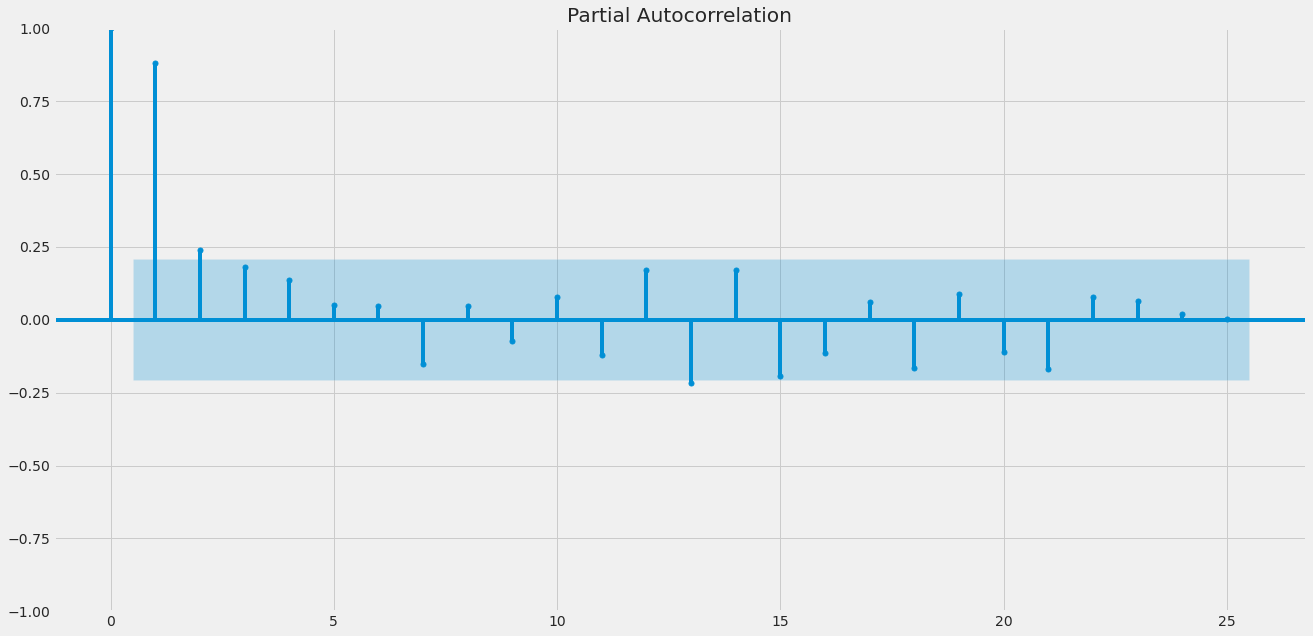

In [17]:
# autocorrelation decreasing over time
# blue band is confidence interval at 95%, meaning we have to worry only on values that step out of blue zone

plot_pacf(xresiduals,lags=25)
print()

In [18]:
# the trend component is making things difficult as the values in lags 1 stand out of blue zone
# Autocorrelation tells us the observation depends of the previous one
# Partial autocorrelation is de dependent

Dedicated notebook: [https://www.kaggle.com/konradb/practical-time-series-pt-4-prophet](https://www.kaggle.com/konradb/practical-time-series-pt-4-prophet)

Dataset: [https://www.kaggle.com/piantic/autonomous-greenhouse-challengeagc-2nd-2019](https://www.kaggle.com/piantic/autonomous-greenhouse-challengeagc-2nd-2019)

In [19]:
from prophet import Prophet

In [20]:
# Read the dataset
xdat = pd.read_csv("GreenhouseClimate.csv", dtype=object)

# Strip the space in front of each value
# xdat = xdat.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

xdat.head(3)

,%time,AssimLight,BlackScr,CO2air,Cum_irr,EC_drain_PC,EnScr,HumDef,PipeGrow,PipeLow,...,t_rail_min_sp,t_rail_min_vip,t_vent_sp,t_ventlee_vip,t_ventwind_vip,water_sup,water_sup_intervals_sp_min,water_sup_intervals_vip_min,window_pos_lee_sp,window_pos_lee_vip
0,43815.00000,100,35,509,31.6,0.3,96,8.8,0.0,49.9,...,NaN,0.0,NaN,25.0,26.0,263.0,NaN,10,NaN,1.2
1,43815.00347,100,85,484,31.8,0.3,96,9.2,0.0,48.5,...,NaN,0.0,NaN,25.0,26.0,265.0,NaN,10,NaN,1.2
2,43815.00694,100,96,475,31.8,0.3,96,9.1,0.0,46.8,...,NaN,0.0,NaN,25.0,26.0,265.0,NaN,10,NaN,1.2


In [21]:
# Convert object column dtype to float
xdat = xdat.astype(float)

xdat.head(3)

,%time,AssimLight,BlackScr,CO2air,Cum_irr,EC_drain_PC,EnScr,HumDef,PipeGrow,PipeLow,...,t_rail_min_sp,t_rail_min_vip,t_vent_sp,t_ventlee_vip,t_ventwind_vip,water_sup,water_sup_intervals_sp_min,water_sup_intervals_vip_min,window_pos_lee_sp,window_pos_lee_vip
0,43815.00000,100.0,35.0,509.0,31.6,0.3,96.0,8.8,0.0,49.9,...,NaN,0.0,NaN,25.0,26.0,263.0,NaN,10.0,NaN,1.2
1,43815.00347,100.0,85.0,484.0,31.8,0.3,96.0,9.2,0.0,48.5,...,NaN,0.0,NaN,25.0,26.0,265.0,NaN,10.0,NaN,1.2
2,43815.00694,100.0,96.0,475.0,31.8,0.3,96.0,9.1,0.0,46.8,...,NaN,0.0,NaN,25.0,26.0,265.0,NaN,10.0,NaN,1.2


In [22]:
xdat.rename(columns={"%time": "time"}, inplace=True)
# xdat['time'] = xdat['time'].astype(float)
xdat['time'] = pd.to_datetime(xdat['time'], unit = 'D', origin = "1899-12-30")
xdat.head(3)

,time,AssimLight,BlackScr,CO2air,Cum_irr,EC_drain_PC,EnScr,HumDef,PipeGrow,PipeLow,...,t_rail_min_sp,t_rail_min_vip,t_vent_sp,t_ventlee_vip,t_ventwind_vip,water_sup,water_sup_intervals_sp_min,water_sup_intervals_vip_min,window_pos_lee_sp,window_pos_lee_vip
0,2019-12-16 00:00:00.000000000,100.0,35.0,509.0,31.6,0.3,96.0,8.8,0.0,49.9,...,NaN,0.0,NaN,25.0,26.0,263.0,NaN,10.0,NaN,1.2
1,2019-12-16 00:04:59.808000256,100.0,85.0,484.0,31.8,0.3,96.0,9.2,0.0,48.5,...,NaN,0.0,NaN,25.0,26.0,265.0,NaN,10.0,NaN,1.2
2,2019-12-16 00:09:59.616000000,100.0,96.0,475.0,31.8,0.3,96.0,9.1,0.0,46.8,...,NaN,0.0,NaN,25.0,26.0,265.0,NaN,10.0,NaN,1.2


In [23]:
list1 = ['time', 'Tair']

list2 = ['co2_sp', 'dx_sp', 't_rail_min_sp', 't_grow_min_sp',
         'assim_sp', 'scr_enrg_sp', 'scr_blck_sp', 't_heat_sp',
         't_vent_sp', 'window_pos_lee_sp', 'water_sup_intervals_sp_min',
         'int_blue_sp', 'int_red_sp', 'int_farred_sp',
         'int_white_sp']

xdat = xdat[list1 + list2]
xdat.head(3)

,time,Tair,co2_sp,dx_sp,t_rail_min_sp,t_grow_min_sp,assim_sp,scr_enrg_sp,scr_blck_sp,t_heat_sp,t_vent_sp,window_pos_lee_sp,water_sup_intervals_sp_min,int_blue_sp,int_red_sp,int_farred_sp,int_white_sp
0,2019-12-16 00:00:00.000000000,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-12-16 00:04:59.808000256,21.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.0,0.0,0.0,0.0
2,2019-12-16 00:09:59.616000000,21.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.0,0.0,0.0,0.0


In [24]:
xdat2 = xdat.resample('H', on = 'time').mean().reset_index()[list1+list2]

xdat2.head(3)

,time,Tair,co2_sp,dx_sp,t_rail_min_sp,t_grow_min_sp,assim_sp,scr_enrg_sp,scr_blck_sp,t_heat_sp,t_vent_sp,window_pos_lee_sp,water_sup_intervals_sp_min,int_blue_sp,int_red_sp,int_farred_sp,int_white_sp
0,2019-12-16 00:00:00,21.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.0,0.0,0.0,0.0
1,2019-12-16 01:00:00,20.738462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.0,0.0,0.0,0.0
2,2019-12-16 02:00:00,20.927273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.0,0.0,0.0,0.0


In [25]:
# Missing  values
np.isnan(xdat2[['Tair'] + list2]).describe()

,Tair,co2_sp,dx_sp,t_rail_min_sp,t_grow_min_sp,assim_sp,scr_enrg_sp,scr_blck_sp,t_heat_sp,t_vent_sp,window_pos_lee_sp,water_sup_intervals_sp_min,int_blue_sp,int_red_sp,int_farred_sp,int_white_sp
count,3985,3985,3985,3985,3985,3985,3985,3985,3985,3985,3985,3985,3985,3985,3985,3985
unique,2,2,2,2,1,2,2,2,2,2,2,2,1,1,1,1
top,False,True,True,True,True,True,True,True,True,False,True,True,False,False,False,False
freq,3983,3069,3918,3918,3985,3854,3639,3693,2352,2149,3912,3271,3985,3985,3985,3985


In [26]:
xdat2.dropna(subset = ['Tair'], inplace = True)

<AxesSubplot:>

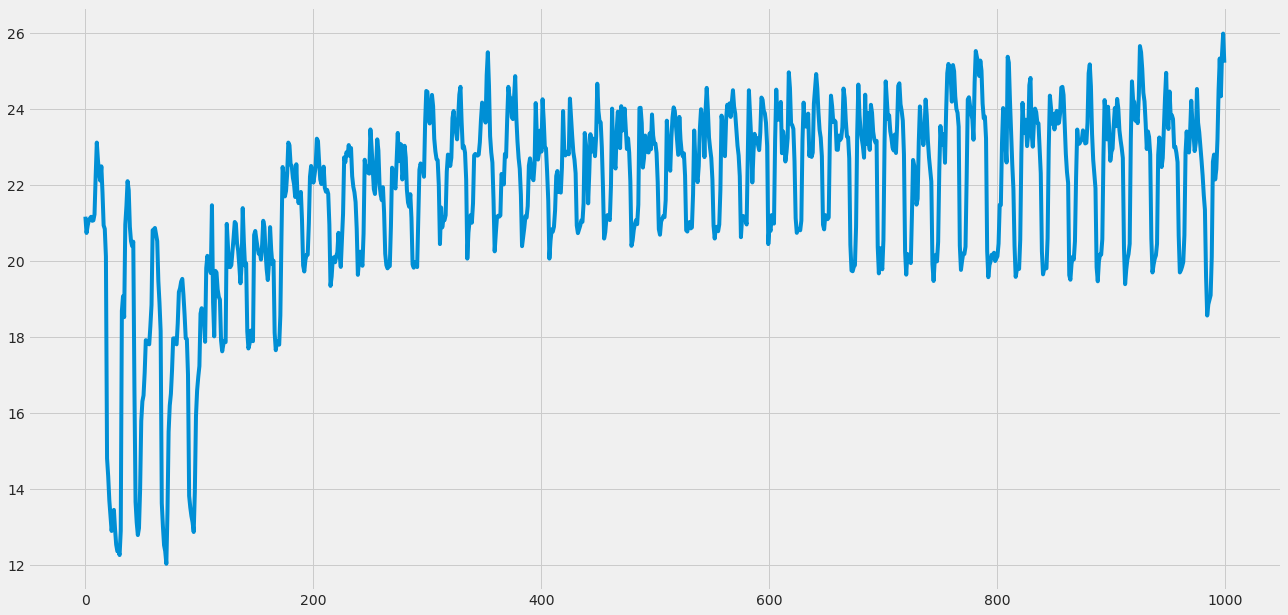

In [27]:
xdat2['Tair'][0:1000].plot()

<AxesSubplot:>

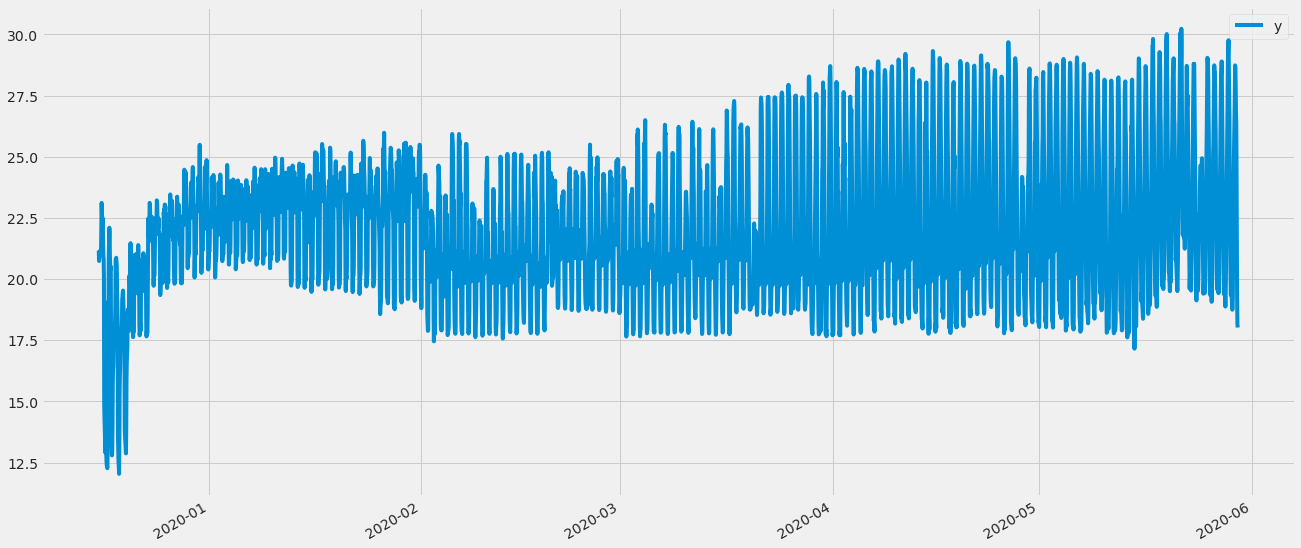

In [28]:
# Rename columns in order to fit prophet input standard
df = xdat2[['time','Tair']].rename(columns={"time":"ds","Tair":"y"})
df.set_index("ds").plot(figsize=(CFG.img_dim1,CFG.img_dim2), xlabel = '')

In [29]:
# Instantiate the model. Weekly seasonality disabled because the data does not include >2 seasons(years)
m = Prophet(weekly_seasonality=False,
            interval_width= 0.95,
            mcmc_samples = 10)

In [30]:
m.fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (i


Gradient evaluation took 0.002566 seconds
1000 transitions using 10 leapfrog steps per transition would take 25.66 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.002953 seconds
1000 transitions using 10 leapfrog steps per transition would take 29.53 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20



Gradient evaluation took 0.003734 seconds
Gradient evaluation took 0.003347 seconds
1000 transitions using 10 leapfrog steps per transition would take 37.34 seconds.
1000 transitions using 10 leapfrog steps per transition would take 33.47 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!




         performed for num_warmup < 20
         performed for num_warmup < 20


Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 2 / 10 [ 20%]  (Warmup)
Iteration: 2 / 10 [ 20%]  (Warmup)
Iteration: 3 / 10 [ 30%]  (Warmup)
Itera

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of th

/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


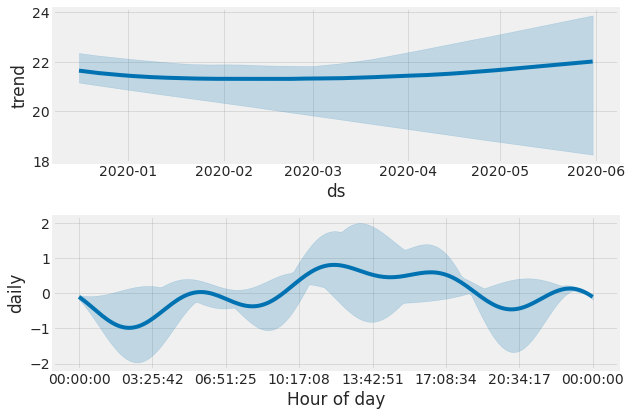

In [31]:
future = m.make_future_dataframe(periods = 24, freq = 'H')
forecast = m.predict(future)
m.plot_components(forecast)
print()

In [32]:
# If the confidence interval is not zero

# Recommended read: Neural prophet NN Component

In [33]:
from prophet.diagnostics import cross_validation, performance_metrics

In [34]:
df_cv = cross_validation(m, initial='3700 hours', period='24 hours', horizon='24 hours')
df_cv.head()

INFO:prophet:Making 11 forecasts with cutoffs between 2020-05-18 23:00:00 and 2020-05-28 23:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

If this warning occurs sporadically, such as for highly constraine


Gradient evaluation took 0.002153 seconds
1000 transitions using 10 leapfrog steps per transition would take 21.53 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.002398 seconds
1000 transitions using 10 leapfrog steps per transition would take 23.98 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.00249 seconds
1000 transitions using 10 leapfrog steps per transition would take 24.9 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.003062 seconds
1000 transitions using 10 leapfrog steps per transition would take 30.62 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20

Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 2 / 10 [ 20%]  (Warmup)
Iteration: 2 / 10 [ 20%]  (Warmup)
Iterati

/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' 


Gradient evaluation took 0.002103 seconds
1000 transitions using 10 leapfrog steps per transition would take 21.03 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.002319 seconds
1000 transitions using 10 leapfrog steps per transition would take 23.19 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.002428 seconds
1000 transitions using 10 leapfrog steps per transition would take 24.28 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.002465 seconds
1000 transitions using 10 leapfrog steps per transition would take 24.65 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20

Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 2 / 10 [ 20%]  (Warmup)
Iteration: 2 / 10 [ 20%]  (Warmup)
Iteration: 3 / 10 [ 30%]  (Warmup)
Itera

/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' 


Gradient evaluation took 0.002187 seconds
1000 transitions using 10 leapfrog steps per transition would take 21.87 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.002273 seconds
1000 transitions using 10 leapfrog steps per transition would take 22.73 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.002371 seconds
1000 transitions using 10 leapfrog steps per transition would take 23.71 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.00261 seconds
1000 transitions using 10 leapfrog steps per transition would take 26.1 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20

Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 2 / 10 [ 20%]  (Warmup)
Iteration: 3 / 10 [ 30%]  (Warmup)
Iteration: 2 / 10 [ 20%]  (Warmup)
Iterati

/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' 


Gradient evaluation took 0.002198 seconds
1000 transitions using 10 leapfrog steps per transition would take 21.98 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.00238 seconds
1000 transitions using 10 leapfrog steps per transition would take 23.8 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.002338 seconds
1000 transitions using 10 leapfrog steps per transition would take 23.38 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.002545 seconds
1000 transitions using 10 leapfrog steps per transition would take 25.45 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20

Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 2 / 10 [ 20%]  (Warmup)
Iteration: 3 / 10 [ 30%]  (Warmup)
Iterati

/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' 


Gradient evaluation took 0.002252 seconds
1000 transitions using 10 leapfrog steps per transition would take 22.52 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.002395 seconds
1000 transitions using 10 leapfrog steps per transition would take 23.95 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.002473 seconds
1000 transitions using 10 leapfrog steps per transition would take 24.73 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.002398 seconds
1000 transitions using 10 leapfrog steps per transition would take 23.98 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20

Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 2 / 10 [ 20%]  (Warmup)
Itera

/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' 


Gradient evaluation took 0.00215 seconds
1000 transitions using 10 leapfrog steps per transition would take 21.5 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.002321 seconds
1000 transitions using 10 leapfrog steps per transition would take 23.21 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.002397 seconds
1000 transitions using 10 leapfrog steps per transition would take 23.97 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.002409 seconds
1000 transitions using 10 leapfrog steps per transition would take 24.09 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20

Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 2 / 10 [ 20%]  (Warmup)
Iteration: 2 / 10 [ 20%]  (Warmup)
Iterati

/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' 


Gradient evaluation took 0.002167 seconds
1000 transitions using 10 leapfrog steps per transition would take 21.67 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.002214 seconds
1000 transitions using 10 leapfrog steps per transition would take 22.14 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.002386 seconds
1000 transitions using 10 leapfrog steps per transition would take 23.86 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.00257 seconds
1000 transitions using 10 leapfrog steps per transition would take 25.7 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20

Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 2 / 10 [ 20%]  (Warmup)
Iteration: 3 / 10 [ 30%]  (Warmup)
Iteration: 2 / 10 [ 20%]  (Warmup)
Iterati

/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' 


Gradient evaluation took 0.002264 seconds
1000 transitions using 10 leapfrog steps per transition would take 22.64 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.002201 seconds
1000 transitions using 10 leapfrog steps per transition would take 22.01 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.002254 seconds
1000 transitions using 10 leapfrog steps per transition would take 22.54 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.002633 seconds
1000 transitions using 10 leapfrog steps per transition would take 26.33 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20

Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 2 / 10 [ 20%]  (Warmup)
Iteration: 2 / 10 [ 20%]  (Warmup)
Itera

/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' 


Gradient evaluation took 0.002185 seconds
1000 transitions using 10 leapfrog steps per transition would take 21.85 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.00227 seconds
1000 transitions using 10 leapfrog steps per transition would take 22.7 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.002294 seconds
1000 transitions using 10 leapfrog steps per transition would take 22.94 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.00227 seconds
1000 transitions using 10 leapfrog steps per transition would take 22.7 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20

Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 2 / 10 [ 20%]  (Warmup)
Iteration: 2 / 10 [ 20%]  (Warmup)
Iteration

/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' 


Gradient evaluation took 0.002255 seconds
1000 transitions using 10 leapfrog steps per transition would take 22.55 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.002197 seconds
1000 transitions using 10 leapfrog steps per transition would take 21.97 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.002306 seconds
1000 transitions using 10 leapfrog steps per transition would take 23.06 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.00242 seconds
1000 transitions using 10 leapfrog steps per transition would take 24.2 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20

Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 2 / 10 [ 20%]  (Warmup)
Iteration: 2 / 10 [ 20%]  (Warmup)
Iteration: 3 / 10 [ 30%]  (Warmup)
Iterati

/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' 


Gradient evaluation took 0.00225 seconds
1000 transitions using 10 leapfrog steps per transition would take 22.5 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.00241 seconds
1000 transitions using 10 leapfrog steps per transition would take 24.1 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.002325 seconds
1000 transitions using 10 leapfrog steps per transition would take 23.25 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


Gradient evaluation took 0.002452 seconds
1000 transitions using 10 leapfrog steps per transition would take 24.52 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20

Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 1 / 10 [ 10%]  (Warmup)
Iteration: 2 / 10 [ 20%]  (Warmup)
Iteration

/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-05-19 00:00:00,20.036097,-26.463765,62.097018,19.691667,2020-05-18 23:00:00
1,2020-05-19 01:00:00,20.646956,-21.842701,63.377070,19.946154,2020-05-18 23:00:00
2,2020-05-19 02:00:00,21.194366,-20.980719,60.828491,19.800000,2020-05-18 23:00:00
3,2020-05-19 03:00:00,21.451205,-17.721355,62.859028,19.591667,2020-05-18 23:00:00
4,2020-05-19 04:00:00,21.407378,-17.820955,61.201695,19.969231,2020-05-18 23:00:00


In [35]:
df_p1 = performance_metrics(df_cv)
df_p1.head(10)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 03:00:00,7.789334,2.790938,2.494120,0.126384,0.133314,0.117151,1.0
1,0 days 04:00:00,9.556638,3.091381,2.833763,0.144290,0.162556,0.132888,1.0
2,0 days 05:00:00,10.922193,3.304874,3.081149,0.157798,0.174409,0.144646,1.0
3,0 days 06:00:00,10.766165,3.281184,3.078991,0.157336,0.184218,0.144413,1.0
4,0 days 07:00:00,8.864367,2.977309,2.744833,0.138141,0.158598,0.127742,1.0
5,0 days 08:00:00,5.527306,2.351022,2.033239,0.099173,0.095999,0.093050,1.0
6,0 days 09:00:00,2.838346,1.684739,1.370518,0.063368,0.046776,0.061103,1.0
7,0 days 10:00:00,1.706766,1.306432,1.009314,0.043558,0.031722,0.043621,1.0
8,0 days 11:00:00,2.147192,1.465330,1.082443,0.043760,0.030711,0.045192,1.0
9,0 days 12:00:00,3.799179,1.949148,1.522940,0.058378,0.050787,0.061203,1.0


In [36]:
from sklearn.linear_model import Ridge
from sklearn.feature_selection import RFE
# incorporate the climate and irrigation setpoints
xdat1 = xdat2.copy()
xdat2 = xdat2.fillna(0)

estimator = Ridge()
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(xdat2[list2], xdat2['Tair'])
#
to_keep = xdat2[list2].columns[selector.support_]


print(to_keep)

Index(['dx_sp', 't_vent_sp', 'window_pos_lee_sp'], dtype='object')


In [37]:
df = xdat2[['time', 'Tair']].rename(columns={'time':'ds', 'Tair':"y"})

m = Prophet(weekly_seasonality=False, interval_width=0.95)

# add the regressors to the dataframe holding the data

for f in to_keep:
    df[f] = xdat2[f]
    m.add_regressor(f)

# the rest proceeds as before
m.fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -38.2464


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        9733.9      0.001236        416.36           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9773.29    0.00464726       401.776      0.9175      0.9175      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9785.63    0.00746883       181.444           1           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9794.87   0.000479992       130.949           1           1      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       9797.93     0.0103009       416.821           1           1      561   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

In [38]:
df_cv= cross_validation(m, initial='3700 hours', period = '24 hours', horizon= '24 hours')
df_p2 = performance_metrics(df_cv)

INFO:prophet:Making 11 forecasts with cutoffs between 2020-05-18 23:00:00 and 2020-05-28 23:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

Initial log joint probability = -24.4621


/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9068.67      0.015221       1618.37      0.2168           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9102.01     0.0244295       819.426           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9120.12   0.000783935       174.621           1           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     354       9123.41    5.2745e-05       114.928   2.954e-07       0.001      445  LS failed, Hessian reset 
     399       9124.77   0.000364655       115.713           1           1      497   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       9127.46     0.0118539       664.315      0.4613           1      6

/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -23.2963
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9146.83     0.0099038       1662.08           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9179.54    0.00406561       657.532      0.2851           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        9188.4    0.00508736       444.776           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        9196.4     0.0017082       468.594           1           1      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       9203.27   0.000524492       194.901      0.1119      0.4721      574   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -21.8692
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9207.66    0.00990289       725.044           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9239.95    0.00527081       371.025           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9250.51    0.00289818       111.482       1.432      0.2202      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9256.62   0.000590979       257.143      0.4297      0.4297      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     488       9259.84   5.30985e-05       122.544   3.342e-07       0.001      594  LS failed, Hessian reset 
     499       9260.42   0.000129291    

/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -19.9858
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9269.12    0.00713426       1037.83           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9290.42    0.00132851       221.058           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9297.88    0.00130564       240.404      0.7391      0.7391      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9311.25    0.00170573       168.118           1           1      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       9316.84   8.14428e-05        315.54      0.2343      0.2343      560   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -26.7561
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9334.37     0.0229331       697.378           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9356.29    0.00138852       130.358           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9364.78    0.00928192       613.928           1           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9371.38   0.000212669        138.43      0.3198      0.3198      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       9377.35     0.0109317       521.902           1           1      553   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -29.4208
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9392.32     0.0040845       1410.28      0.4957           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9417.57      0.009339       874.464           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9431.73    0.00111039        194.33           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9437.17    0.00383689       320.496           1           1      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       9441.32    0.00125475       240.821      0.6283      0.6283      565   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -28.1313
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        9447.9     0.0156256       577.921           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9477.07    0.00430347        393.12           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     247       9482.73   6.22968e-05       145.018   4.181e-07       0.001      322  LS failed, Hessian reset 
     299       9485.73    0.00097915        157.93           1           1      377   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     353       9491.61   0.000345105       322.978   2.552e-06       0.001      469  LS failed, Hessian reset 
     399       9494.18    0.00125389       111.671           1           1      521   
    Iter      log pro

/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -28.7194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9513.08    0.00548313       491.084           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        9538.9    0.00985184       345.689           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9547.21   0.000967927       243.614           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9559.83   0.000273647       315.918     0.02923           1      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       9564.45   0.000371756       223.804      0.8124      0.8124      555   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -27.8718
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9576.97     0.0105767       1494.59           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9599.74    0.00266328       642.148      0.2319           1      213   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9612.31    0.00606138        207.08      0.8104      0.8104      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9616.16    0.00169526       153.835      0.9757      0.9757      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       9622.28     0.0126702       478.177           1           1      551   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -29.1435
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9643.14     0.0117054       1908.29      0.4274      0.4274      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9665.07     0.0104595       468.962           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9679.06    0.00958013       574.241           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9687.59    0.00261062       425.892           1           1      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       9691.77   0.000323036       154.378           1           1      563   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -29.689
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9689.47     0.0103126       562.097           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9718.57     0.0111622       422.423           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9731.28     0.0017911       165.194      0.8991      0.8991      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9742.38   5.66792e-05       137.174      0.8253      0.8253      441   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       9744.92    0.00616938       345.472           1           1      566   
    Iter      log prob        ||dx||      ||grad||       alpha   

/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/noone/miniconda3/envs/pytorch/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [39]:
comparison = pd.DataFrame()
comparison['raw'] = df_p1.mean(axis=0)[1:0]
comparison['covariates'] = df_p2.mean(axis=0)[1:]

print(comparison)

          raw covariates
mse       NaN   3.134077
rmse      NaN   1.668162
mae       NaN   1.417303
mape      NaN   0.058687
mdape     NaN   0.053353
smape     NaN   0.059239
coverage  NaN   0.938017


INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.95% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.95% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 131
INFO:NP.config:Auto-set epochs to 131


  0%|          | 0/140 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.99E-02, min: 2.07E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.99E-02, min: 2.07E+00


  0%|          | 0/140 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.99E-02, min: 2.07E+00
INFO:NP.utils_torch:lr-range-test results: steep: 4.99E-02, min: 2.07E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.29E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 6.29E-02
Epoch[131/131]: 100%|██████████| 131/131 [00:17<00:00,  7.68it/s, SmoothL1Loss=0.00489, MAE=1.26, RMSE=1.56, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.95% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 99.95% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO:NP.df_utils:Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 95.833% of the data.
INFO:NP.df_utils:Major frequency H corresponds to 95.833% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to 

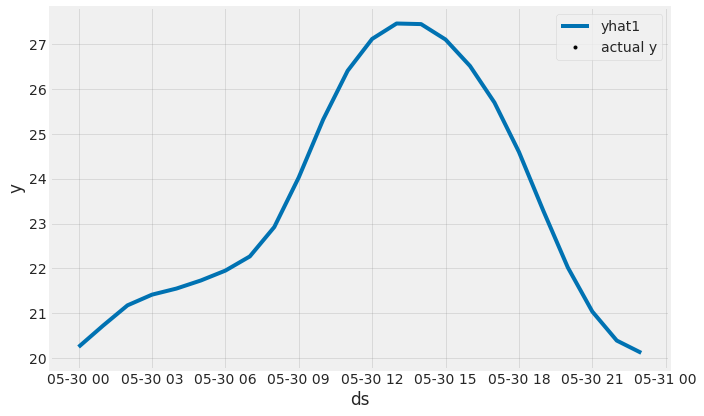

In [40]:
from neuralprophet import NeuralProphet

df = xdat2[['time','Tair']].rename(columns={'time':'ds','Tair':'y'})

model = NeuralProphet(weekly_seasonality = False)

model.fit(df, freq='H')

df_predict = model.make_future_dataframe(df, periods=24)
df_predict = model.predict(df_predict)
fig = model.plot(df_predict)